# TP 1: Analisis Exploratorio
### Arrancando con Jupyter

In [1]:
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:90% !important; }</style>"))
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline

In [3]:
# Carga de archivos
post_educacion = pd.read_csv('../data/fiuba_1_postulantes_educacion.csv', dtype = {
    'nombre': 'category',
    'estado': 'category'
})
post_gen_edad = pd.read_csv('../data/fiuba_2_postulantes_genero_y_edad.csv', dtype = {
    'sexo': 'category'    
})

vistas = pd.read_csv('../data/fiuba_3_vistas.csv', parse_dates=['timestamp'])
postulaciones = pd.read_csv('../data/fiuba_4_postulaciones.csv', parse_dates=['fechapostulacion'])
avisos_online = pd.read_csv('../data/fiuba_5_avisos_online.csv')

avisos_detalles = pd.read_csv('../data/fiuba_6_avisos_detalle.csv', dtype= {
    'nombre_zona': 'category',
    'ciudad': 'category',
    'tipo_de_trabajo': 'category',
    'nivel_laboral': 'category',
})

# Ajustes en los archivos antes de procesar

In [4]:
# Recorto la columna idpais ya que no es necesaria.
avisos_detalles.drop('idpais', axis=1, inplace=True)

In [5]:
# Agrupo las áreas parecidas.
areas_agrupadas = pd.read_csv('../extraData/areas_agrupadas.csv')
avisos_detalles = pd.merge(avisos_detalles, areas_agrupadas, how='inner', on='nombre_area')
avisos_detalles['nombre_area'] = avisos_detalles['nuevo_nombre_area']
avisos_detalles.drop('nuevo_nombre_area', axis=1, inplace=True)

In [6]:
# Convierto el nombre del area a category.
avisos_detalles['nombre_area'] = avisos_detalles['nombre_area'].astype('category')

In [7]:
# Agrego tipo categorico y modifico el tipo de dato de la fecha.
post_gen_edad.fechanacimiento = post_gen_edad.fechanacimiento.apply(pd.to_datetime, errors='coerce')

now = pd.Timestamp(dt.datetime.now())
pd.to_datetime(now)
post_gen_edad['edad'] = (now - pd.to_datetime(post_gen_edad['fechanacimiento'])).astype('<m8[Y]')

# Empieza el analisis

In [8]:
# Asigno puntajes a los diferentes niveles educativos encontrados para poder 
# obtener asi la educacion mas valiosa de cada postulante.
valores_educacion = pd.DataFrame({
    'nombre': ['Otro',  'Otro',  'Otro',  'Secundario',  'Secundario',  'Secundario',  'Terciario/Técnico', 'Universitario',  \
              'Terciario/Técnico', 'Universitario',  'Terciario/Técnico', 'Universitario',  'Posgrado', 'Master','Posgrado', \
              'Master','Posgrado', 'Master','Doctorado','Doctorado','Doctorado'],
    'estado': ['Abandonado', 'En Curso','Graduado','Abandonado', 'En Curso','Graduado','Abandonado', 'Abandonado', 'En Curso',\
              'En Curso','Graduado','Graduado','Abandonado', 'Abandonado', 'En Curso','En Curso','Graduado','Graduado',\
              'Abandonado', 'En Curso','Graduado'],
    'valor_educacion': [1 , 2 , 3 , 4, 5,6 ,7 ,8 ,9,10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]})

# Y le pongo las mismas categorias que ya habia encontrado previamente.
valores_educacion.nombre = valores_educacion.nombre.astype((pd.api.types.CategoricalDtype(post_educacion.nombre.cat.categories)))
valores_educacion.estado = valores_educacion.estado.astype((pd.api.types.CategoricalDtype(post_educacion.estado.cat.categories)))

# Cuento cuantos registros tengo actualmente, para comprobar que no hay errores mas adelante.
# post_educacion.count()

In [9]:
# Hago el join para aplicar puntajes a las educaciones de los postulantes.
post_educacion = pd.merge(post_educacion, valores_educacion, how='inner', \
                          left_on=['nombre','estado'], right_on = ['nombre','estado'])

# Cuento cuantos registros tengo actualmente, para comprobar que no hay errores mas adelante.
# post_educacion.count()

In [10]:
# Busco la maxima educacion que tiene cada postulante.
max_post_educacion = post_educacion.groupby(['idpostulante'])['valor_educacion'].max().reset_index()

# Controlo cuantas lineas me devolvio.
# max_post_educacion.count()

In [11]:
# Hago el join para filtrar todas las educaciones que no me interesan, dejando solo la maxima educacion.
post_educacion = pd.merge(post_educacion, max_post_educacion,  how='inner', \
                          left_on=['idpostulante','valor_educacion'], \
                          right_on = ['idpostulante','valor_educacion'])

# post_educacion.count()

In [12]:
post_educacion_graph = post_educacion.groupby(['nombre', 'estado', 'valor_educacion'])['idpostulante'].count().reset_index()
post_educacion_graph['resumen'] = post_educacion_graph.nombre.astype('object') + ' ' + post_educacion_graph.estado.astype('object')
post_educacion_graph.sort_values('valor_educacion', inplace=True)
post_educacion_graph.reset_index()
post_educacion_graph.drop(['nombre', 'estado', 'valor_educacion'], axis=1, inplace=True)
post_educacion_graph.rename(columns= {'idpostulante' : 'Cantidad de Postulantes'}, inplace=True)

post_educacion_graph.head(22)

,Cantidad de Postulantes,resumen
6,219,Otro Abandonado
7,186,Otro En Curso
8,933,Otro Graduado
12,2681,Secundario Abandonado
13,3397,Secundario En Curso
14,56333,Secundario Graduado
15,3034,Terciario/Técnico Abandonado
18,7122,Universitario Abandonado
16,10690,Terciario/Técnico En Curso
19,41097,Universitario En Curso


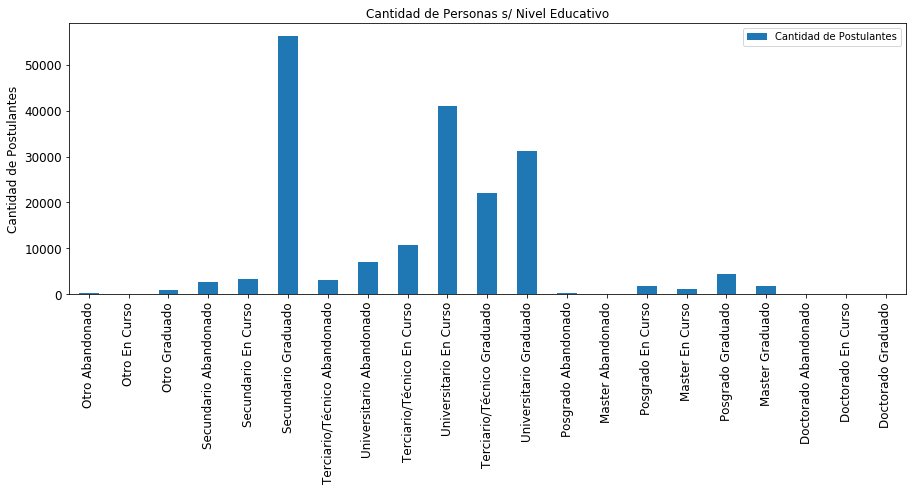

In [13]:
post_educacion_graph2 = post_educacion_graph[['resumen','Cantidad de Postulantes']].plot(kind='bar', x = 'resumen',                                                           
                                                           title ="Cantidad de Personas s/ Nivel Educativo", 
                                                           figsize=(15, 5), legend=True, fontsize=12)
post_educacion_graph2.set_xlabel("", fontsize=12)
post_educacion_graph2.set_ylabel("Cantidad de Postulantes", fontsize=12)
plt.show()

# Busco los avisos mas populares

In [14]:
# Busco cuales son los avisos mas populares, basandome en la cantidad de postulaciones sobre la cantidad de dias que lleva online.
avisos_popularidad = postulaciones.groupby(['idaviso'])['fechapostulacion'].agg(['min', 'max', 'count']).reset_index()
avisos_popularidad['cantidad_dias'] = (avisos_popularidad['max'] - \
                                       avisos_popularidad['min']).apply(lambda x: x.days).astype(int) + 1
avisos_popularidad.drop(['min', 'max'], axis=1, inplace=True)

avisos_popularidad['popularidad_en_postulaciones'] = avisos_popularidad['count'] / avisos_popularidad['cantidad_dias']
avisos_popularidad.drop(['count', 'cantidad_dias'], axis=1, inplace=True)
avisos_popularidad.sort_values('popularidad_en_postulaciones', ascending=False, inplace=True)

# Le calculo la probabilidad y lo agrego a la tabla de avisos_detalles.
avisos_detalles_con_popularidad = pd.merge(avisos_detalles, avisos_popularidad, how='inner', \
                          left_on='idaviso', right_on='idaviso')
avisos_detalles_con_popularidad = avisos_detalles_con_popularidad.sort_values('popularidad_en_postulaciones', ascending=False)
# avisos_detalles.groupby('nombre_area')['popularidad_en_postulaciones'].sum().sort_values(ascending=False)

avisos_detalles_con_popularidad.head(30)

,idaviso,titulo,descripcion,nombre_zona,ciudad,mapacalle,tipo_de_trabajo,nivel_laboral,nombre_area,denominacion_empresa,popularidad_en_postulaciones
7851,1112369306,Recepcionista,"<p style="""">En <span style="""">Deloitte </span>...",Gran Buenos Aires,NaN,NaN,Full-time,Junior,Recepcionista / Secretaria,Deloitte,2450.000000
2541,1112366909,Representantes Telefónicos de Atención al Cliente,<p>Nos encontramos en la búsqueda de <strong>R...,Gran Buenos Aires,NaN,NaN,Part-time,Senior / Semi-Senior,Comercial y Ventas,Grupo Teleperformance,1442.500000
2542,1112366913,Asesores de Ventas en Alto Palermo,<p>Nos encontramos en la búsqueda de nuevos ta...,Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Comercial y Ventas,Garbarino,1171.500000
4174,1112368053,Empleado Administrativo part time,<p>Se busca empleado administrativo turno maña...,Capital Federal,NaN,Sarmiento 1582,Full-time,Junior,Contabilidad y Administración,FF Consultores s.a.,1055.000000
2544,1112367832,Representante de atención al cliente,<p><strong>Adecco Office</strong> está especia...,Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Comercial y Ventas,Adecco -Región Office,1033.000000
10187,1112368214,Pasantias - Cencosud,"<p>Si querés sumarte a un equipo talentoso, lí...",Gran Buenos Aires,NaN,NaN,Pasantia,Junior,Pasantía / Trainee,Cencosud S.A.,964.000000
8706,1112365014,cajeras y repositores,<p>full time</p><p>con experiencia</p><p>resid...,Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Contabilidad y Administración,Supermercado Unisol,944.500000
7683,1111413600,Operador telefónico / Retención y Fidelizació...,"<p>Gestión de seguimiento de reclamos, retenci...",Capital Federal,NaN,Palermo,Part-time,Otro,Comercial y Ventas,Indicom S.A.,917.000000
4044,1112364849,Administrativo General Para Importante Obra so...,<p>Para importante obra social nos encontramos...,Gran Buenos Aires,NaN,NaN,Full-time,Junior,Contabilidad y Administración,GMS S.A.,834.000000
3155,1112345900,Asesores de Atención al Público - Part time,<p><em><strong>¡Sumate al equipo UP!</strong><...,Capital Federal,NaN,Palermo,Part-time,Junior,Consultoria,Universidad de Palermo,830.400000


In [17]:
# avisos_detalles['lugar_de_trabajo'] = \
#     avisos_detalles.descripcion.str.extract(r'Lugar de trabajo:(\s*Av\. [^<\(-]*|[^<.\(-]*)', expand=False)
# avisos_detalles.lugar_de_trabajo = avisos_detalles.lugar_de_trabajo.str.replace('\x96|\xa0|\s+', ' ').str.strip().str.lower()
# avisos_detalles.lugar_de_trabajo = avisos_detalles.lugar_de_trabajo.str.replace('ü', 'u').str.replace('á', 'a').str.replace('é', 'e')
# avisos_detalles.lugar_de_trabajo = avisos_detalles.lugar_de_trabajo.str.replace('í', 'i').str.replace('ó', 'o').str.replace('ú', 'u')
# avisos_detalles.lugar_de_trabajo.fillna(value='')
#      
# avisos_por_lugar_de_trabajo = avisos_detalles.groupby('lugar_de_trabajo')['idaviso'].count().reset_index()
# avisos_por_lugar_de_trabajo.sort_values('idaviso', ascending=False, inplace=True)
# 
#avisos_detalles[avisos_detalles['lugar_de_trabajo'].notnull()].head()

In [20]:
postulaciones_count = pd.merge(postulaciones, post_gen_edad, how='inner', on='idpostulante')
postulaciones_count = pd.merge(postulaciones_count, avisos_detalles, how='inner', on='idaviso')
postulaciones_count.drop(['idaviso', 'idpostulante', 'fechapostulacion', 'fechanacimiento', 'titulo', \
                          'descripcion', 'mapacalle', 'ciudad', 'denominacion_empresa'], inplace=True, axis=1)
postulaciones_count['edad_masc'] = np.where(postulaciones_count['sexo'] == 'MASC', postulaciones_count['edad'], np.NaN)
postulaciones_count['edad_fem'] = np.where(postulaciones_count['sexo'] == 'FEM', postulaciones_count['edad'], np.NaN)
postulaciones_count = postulaciones_count[postulaciones_count['edad'] <= 75]

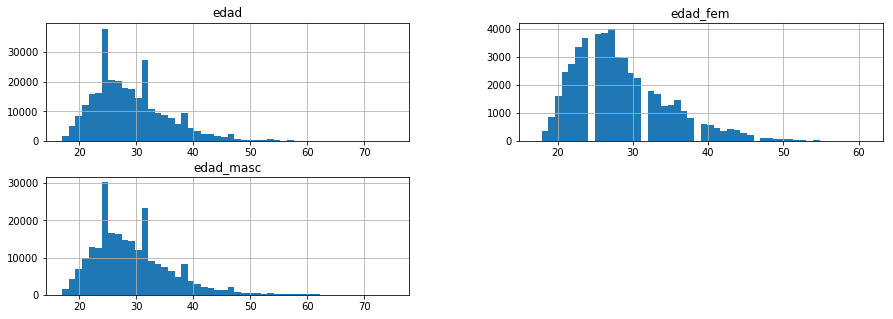

In [32]:
postulaciones_count_graph = postulaciones_count[postulaciones_count['nombre_area'] == 'Producción']
postulaciones_count_graph = pd.DataFrame(postulaciones_count_graph[['edad_masc', 'edad_fem', 'edad']]).reset_index()
postulaciones_count_graph.drop('index', axis=1, inplace=True)
postulaciones_count_graph.hist(bins = 50, alpha=1, stacked=True, figsize=(15, 5))
plt.show()
#postulaciones_count_graph.count()

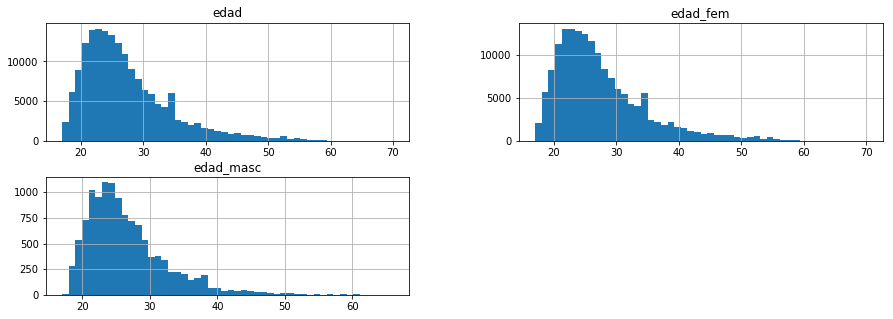

In [33]:
postulaciones_count_graph = postulaciones_count[postulaciones_count['nombre_area'] == 'Recepcionista / Secretaria']
postulaciones_count_graph = pd.DataFrame(postulaciones_count_graph[['edad_masc', 'edad_fem', 'edad']]).reset_index()
postulaciones_count_graph.drop('index', axis=1, inplace=True)
postulaciones_count_graph.hist(bins = 50, alpha=1, stacked=True, figsize=(15, 5))
plt.show()

In [23]:
postulaciones_count_sex = postulaciones_count[['nombre_area', 'sexo']].reset_index()
postulaciones_count_fem = postulaciones_count_sex[postulaciones_count_sex['sexo'] == 'FEM']
postulaciones_count_masc = postulaciones_count_sex[postulaciones_count_sex['sexo'] == 'MASC']

In [24]:
postulaciones_count_masc = pd.DataFrame(postulaciones_count_masc.groupby('nombre_area')['index'].count().reset_index())
postulaciones_count_masc = postulaciones_count_masc.sort_values('index', ascending=False)
postulaciones_count_masc.head()

,nombre_area,index
6,Comercial y Ventas,345457
44,Producción,239258
10,Contabilidad y Administración,232061
31,Logística,128668
9,Consultoria,73372


In [25]:
# postulaciones_count_fem = postulaciones_count_fem.groupby('nombre_area')['index'].count()
postulaciones_count_fem = pd.DataFrame(postulaciones_count_fem.groupby('nombre_area')['index'].count().reset_index())
postulaciones_count_fem = postulaciones_count_fem.sort_values('index', ascending=False)
postulaciones_count_fem.head()

,nombre_area,index
6,Comercial y Ventas,480587
10,Contabilidad y Administración,304457
48,Recepcionista / Secretaria,162717
9,Consultoria,121176
47,RRHH,65485


In [42]:
# Creo un nuevo DataFrame de los postulantes.
postulantes_areas = pd.merge(postulaciones, avisos_detalles, how='inner', on='idaviso')
postulantes_areas = pd.DataFrame(postulantes_areas.groupby(['idpostulante', 'nombre_area'])['idaviso'].count()).reset_index()
postulantes_areas = pd.DataFrame(postulantes_areas.sort_values(['idpostulante','idaviso'], ascending=False))#.reset_index()
postulantes_areas = postulantes_areas.groupby(['idpostulante']).first()
postulantes_areas.drop('idaviso', inplace=True, axis=1)
postulantes_areas = postulantes_areas.reset_index()
postulantes_areas

,idpostulante,nombre_area
0,0z5VvGv,Comercial y Ventas
1,0zB026d,Producción
2,0zB03O9,Comercial y Ventas
3,0zB08lq,Producción
4,0zB0NWY,Consultoria
5,0zB0Xwd,Contabilidad y Administración
6,0zB0YGv,Consultoria
7,0zB0e1d,Comercial y Ventas
8,0zB0eDY,Producción
9,0zB0qGE,Logística


In [40]:
postulantes_areas = pd.merge(post_gen_edad, postulantes_areas, how='inner', on='idpostulante')
# postulantes_areas['edad'] = (now - pd.to_datetime(postulantes_areas['fechanacimiento'])).astype('<m8[Y]')
# post_gen_edad.head()
postulantes_areas.head()

# postulantes = pd.merge(post_educacion, post_gen_edad)
# pd.to_datetime(postulantes['fechanacimiento'])
# postulantes['edad'] = (now - pd.to_datetime(postulantes['fechanacimiento'])).astype('<m8[Y]')
# postulantes.head()

,idpostulante,fechanacimiento,sexo,edad,nombre_area
0,NM5M,1970-12-03,FEM,47.0,Comercial y Ventas
1,5awk,1962-12-04,FEM,55.0,Contabilidad y Administración
2,ZaO5,1978-08-10,FEM,39.0,Recepcionista / Secretaria
3,NdJl,1969-05-09,MASC,48.0,Contabilidad y Administración
4,eo2p,1981-02-16,MASC,37.0,Comercial y Ventas


In [41]:

postulantes_areas = postulantes_areas[postulantes_areas['nombre_area'] == 'Comercial y Ventas']

postulantes_areas_group = postulantes_areas.groupby(['edad'])['idpostulante'].count()


postulantes_areas_group = postulantes_areas_group.reset_index()
postulantes_areas_group.rename({'idpostulante': 'cantidad'}, inplace=True)
postulantes_areas_group

,edad,idpostulante
0,17.0,109
1,18.0,1816
2,19.0,3447
3,20.0,4508
4,21.0,5070
5,22.0,5001
6,23.0,4985
7,24.0,4687
8,25.0,4517
9,26.0,4318
